# Cas kaggel - Classificació Nike Vs Adidas



Judit Panisello NIU: 1605512


## Introducció

En aquesta pràctica tractarem un problema del cas kaggle, més concretament una anàlisi de classificació de les marques `Nike` i `Adidas`.
Començarem fent una anàlisi del dataset, seguit de les modificacions corresponents al dataset.
Després analitzarem dues formes diferents d'enfocar el dataset, la primera classificant cada marca dins del dataset i la segona agrupant cada marca diferent de `Nike` i `Adidas` per tenir només dos variables en l'atribut `Brand`, Nike i Adidas.
Finalment, compararem quina de les dues variacions funciona millor i extreurem d'aquesta els dos millors models de classificació per veure si a partir d'una `PCA` o una `cerca d'hiperparametres` millorem encara mes els resultats.

In [1]:
#Importem llibreries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import sklearn.metrics as metrics
import time

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier
from collections import Counter


C:\Users\Judit\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
NikeAdidas = pd.read_csv('Adidas Vs Nike.csv', header=0, delimiter=',')
NikeAdidas.head()

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating,Reviews,Last Visited
0,Women's adidas Originals NMD_Racer Primeknit S...,AH2430,14999,7499,50,Adidas Adidas ORIGINALS,Channeling the streamlined look of an '80s rac...,4.8,41,2020-04-13T15:06:14
1,Women's adidas Originals Sleek Shoes,G27341,7599,3799,50,Adidas ORIGINALS,"A modern take on adidas sport heritage, tailor...",3.3,24,2020-04-13T15:06:15
2,Women's adidas Swim Puka Slippers,CM0081,999,599,40,Adidas CORE / NEO,These adidas Puka slippers for women's come wi...,2.6,37,2020-04-13T15:06:15
3,Women's adidas Sport Inspired Questar Ride Shoes,B44832,6999,3499,50,Adidas CORE / NEO,"Inspired by modern tech runners, these women's...",4.1,35,2020-04-13T15:06:15
4,Women's adidas Originals Taekwondo Shoes,D98205,7999,3999,50,Adidas ORIGINALS,This design is inspired by vintage Taekwondo s...,3.5,72,2020-04-13T15:06:15


## EDA

### Descripció:
`Product Name`: Nom del producte.

`Product ID`: ID del producte, únic per cada element, no te importància en l'anàlisis.

`Listing Price`: preu original del producte.

`Sale Price`: preu de venda del producte.

`Discount`: descompte aplicat en la venda del producte.

`Brand`: és la variable objectiu i te la marca del producte hi ha 5 tipus diferents:

- Adidas CORE / NEO

- Adidas ORIGINALS

- Adidas Adidas ORIGINALS

- Adidas SPORT PERFORMANCE

- Nike

`Description`: descripció del producte.

`Rating`: cualificacio donada al producte pels usuaris. (avaluada del 0 al 5)

`Reviews`: nombre de qualificacions donades al producte.

`Last Visited`: última visita feta al producte pel client.


In [3]:
NikeAdidas.describe()

,Listing Price,Sale Price,Discount,Rating,Reviews
count,3268.000000,3268.000000,3268.000000,3268.000000,3268.000000
mean,6868.020196,6134.265606,26.875765,3.242105,40.551714
std,4724.659386,4293.247581,22.633487,1.428856,31.543491
min,0.000000,449.000000,0.000000,0.000000,0.000000
25%,4299.000000,2999.000000,0.000000,2.600000,10.000000
50%,5999.000000,4799.000000,40.000000,3.500000,37.000000
75%,8999.000000,7995.000000,50.000000,4.400000,68.000000
max,29999.000000,36500.000000,60.000000,5.000000,223.000000


D'aquí podrem observar que:

- Aques dataset consta de 10 columnes amb un total de 3268 entrades
- La mitjana de reviews són unes 40 valoracions, hi ha moltes opinions
- La diferència entre la mitjana del preu de sortida i el de venda és de 733,75 euros

In [4]:
NikeAdidas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Name   3268 non-null   object 
 1   Product ID     3268 non-null   object 
 2   Listing Price  3268 non-null   int64  
 3   Sale Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Description    3265 non-null   object 
 7   Rating         3268 non-null   float64
 8   Reviews        3268 non-null   int64  
 9   Last Visited   3268 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 255.4+ KB


Tenim 5 variables de tipus `object`, 4 de tipus `int`, una de tipus `float` i
l'atribut `Descripcion` te 3 nulls.

### Ànalisi descriptiu

#### Analisis per Brand

In [5]:
# Arreglem marca mal escrita
NikeAdidas['Brand']= NikeAdidas['Brand'].replace('Adidas Adidas ORIGINALS','Adidas ORIGINALS')
NikeAdidas['Brand'].value_counts()

Adidas CORE / NEO           1111
Adidas ORIGINALS             908
Nike                         643
Adidas SPORT PERFORMANCE     606
Name: Brand, dtype: int64

<AxesSubplot:title={'center':'Products in Brands'}, xlabel='count', ylabel='Brand'>

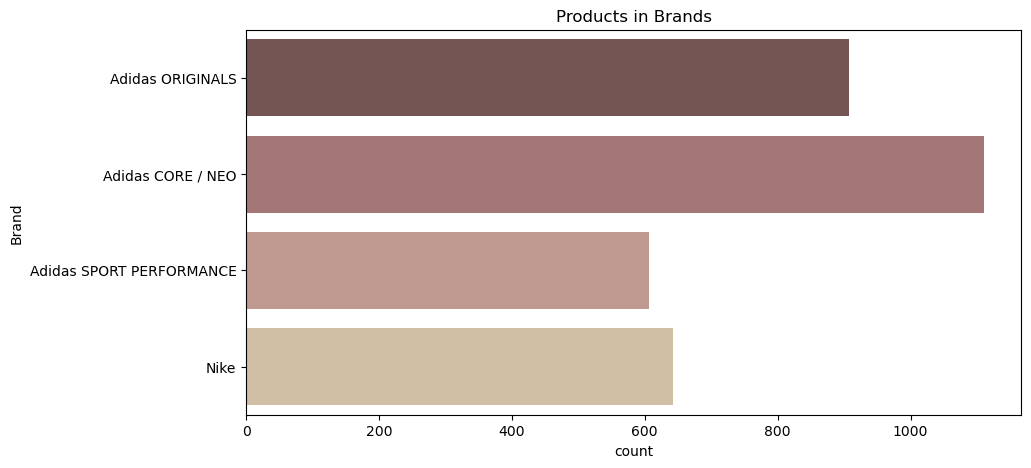

In [6]:
plt.figure(figsize=(10,5))
plt.title("Products in Brands")
plt.ylabel("Brand")
sns.set_palette("pink")
sns.countplot(data=NikeAdidas, y="Brand")

La nostra variable objectiu és `Brand`, és una variable amb 2 marques diferents Nike i Adidas on Adidas està dividida en 3 marques d'Adidas diferents.

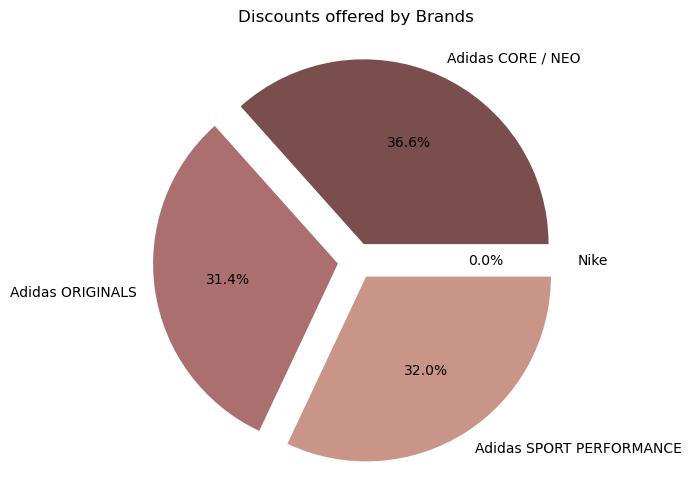

In [7]:
GroupedByBrands=NikeAdidas.groupby(NikeAdidas['Brand'])
AvgDis=GroupedByBrands.mean()
plt.subplots(figsize=(10,6));
discount=np.array(AvgDis.Discount)
label=AvgDis.index
plt.pie(x=discount,autopct="%.1f%%", explode=[0.10]*4,labels=label);
plt.title('Discounts offered by Brands');

Mirem de cada marca quin és el percentatge de descompte que apliquen als seus productes i veiem que les submarques d'Adidas tenen un percentatge molt semblant i que Nike no aplica cap descompte, en un futur reescriurem l'atribut amb el fi de poder utilitzar-lo en l'anàlisi.

#### Anàlisis Nike i Adidas per separat

In [8]:
adidas_brand = NikeAdidas.drop(NikeAdidas[NikeAdidas['Brand'] == "Nike"].index)
nike_brand = NikeAdidas[NikeAdidas['Brand'] == "Nike"]

#### Addidas

C:\Users\Judit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


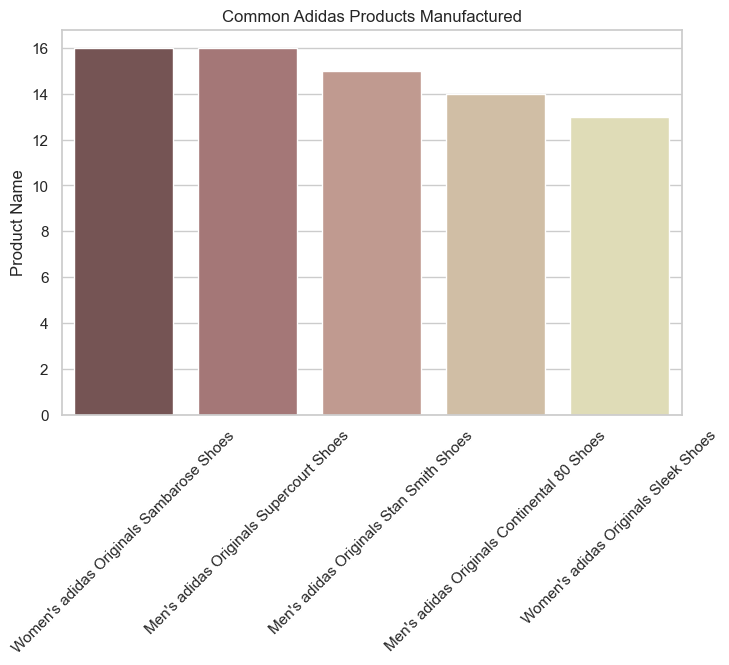

In [9]:
AdidasProducts=adidas_brand['Product Name'].value_counts().head()
sns.set(rc={'figure.figsize':(8,5)});
sns.set_theme(style='whitegrid')
sns.set_palette("pink")
sns.barplot(AdidasProducts.index,AdidasProducts).tick_params(axis='x', rotation=45);
plt.title('Common Adidas Products Manufactured');

El producte que més s'ha fet en Adidas són sabates de la marca originals, també es veu que com a màxim s'ha repetit un producte un total de 16 cops.

In [10]:
adidas_max_rating = adidas_brand['Rating'].max()
adidas_max_rated_product = adidas_brand[adidas_brand['Rating']==adidas_max_rating]
print(f"Adidas's Max Rating: {adidas_max_rating}\n")
print(f"Number of Top Rated Products: {len(adidas_max_rated_product)}")

# Select the reviews and product name
adidas_top_reviews = adidas_max_rated_product[['Product Name', 'Reviews']]
adidas_top_reviews.sort_values(by=['Reviews'], ascending=False)

Adidas's Max Rating: 5.0

Number of Top Rated Products: 87


,Product Name,Reviews
267,Men's adidas Toe Side II Slippers,99
1800,Men's adidas Running Asweego Shoes,99
1849,MEN'S ADIDAS RUNNING NAYO 2.0 SHOES,97
1039,Men's adidas Sport Inspired Court Adapt Shoes,96
2505,Men's adidas Originals Liberty Cup Shoes,94
...,...,...
737,Women's adidas Sport Inspired Kaptir X Shoes,3
73,men's ADIDAS RUNNING NEBULAR 1.0 SHOES,2
683,Men's adidas Swim Salon Slippers,1
1159,men's ADIDAS RUNNING TYLO SHOES,1


Adidas té un total de 87 productes amb la puntuació màxima dels quals la gran majoria venen acompanyats d'un gran nombre de Reviews.

C:\Users\Judit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Judit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


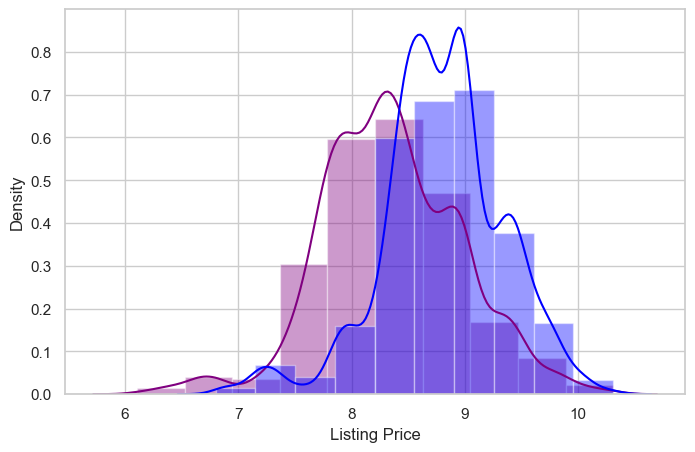

In [11]:
sns.distplot(np.log(adidas_brand['Sale Price']),bins=10,color='purple');
sns.distplot(np.log(adidas_brand['Listing Price']),bins=10,color='blue');

Veiem la relació que tenen les densitats de `Sale Price`, de color lila, i `Listing Price`, de color blau, on es veu com la distribució que segueixen és la mateixa, però `Sale Price` està més desplaçada cap a valors més baixos i té un pic de densitat més baix que `Listing Price`.

#### Nike

C:\Users\Judit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


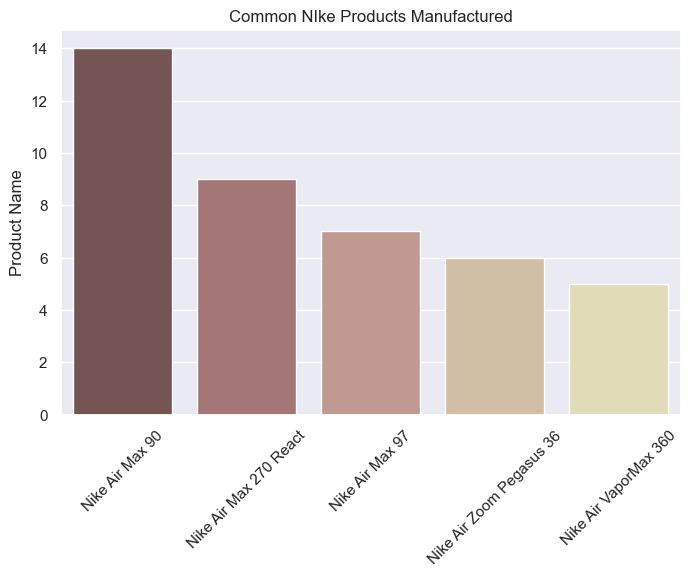

In [12]:
NikeProducts=nike_brand['Product Name'].value_counts().head()
sns.set(rc={'figure.figsize':(8,5)});
sns.set_palette("pink")
sns.barplot(NikeProducts.index,NikeProducts).tick_params(axis='x', rotation=45);
plt.title('Common NIke Products Manufactured');

El producte que més s'ha fet en Nike són sabates Air Max, també es veu que com a màxim s'ha repetit un producte un total de 14 cops.

In [13]:
nike_max_rating = nike_brand['Rating'].max()
nike_max_rated_product = nike_brand[nike_brand['Rating']==nike_max_rating]
print("Nike's Max Rating: {}\n".format(nike_max_rating))
print("Number of Top Rated Products: {}".format(len(nike_max_rated_product)))

# Select the reviews and product name
nike_top_reviews = nike_max_rated_product[['Product Name', 'Reviews']]
nike_top_reviews.sort_values(by=['Reviews'], ascending=False)

Nike's Max Rating: 5.0

Number of Top Rated Products: 120


,Product Name,Reviews
2635,Nike Air Max 90,9
2695,Nike Air Max 90,9
2736,Nike Air Force 1 '07 LV8,6
2965,Nike Air Zoom Wildhorse 5,6
3013,Nike Air Max 720 (OBJ),5
...,...,...
2912,Nike React Presto Premium,1
2910,Nike Tiempo Legend 8 Academy IC,1
2907,Nike Zoom Vomero 5 SE SP,1
2899,Nike Air Max 270 SE,1


Adidas té un total de 120 productes amb la puntuació màxima dels quals no podríem assegurar la veracitat de la nota, ja que com a màxim els productes de Nike tenen només 9 Reviews, a diferència d'Adidas que en té com a màxim 99.

C:\Users\Judit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Judit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


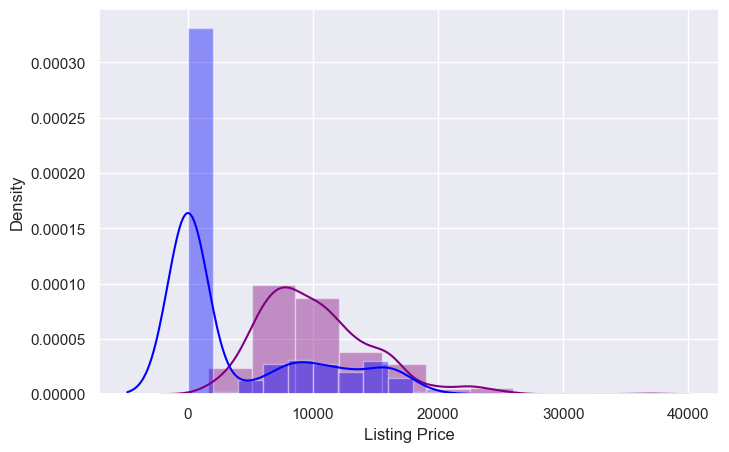

In [14]:
sns.distplot(nike_brand['Sale Price'],bins=10,color='purple');
sns.distplot(nike_brand['Listing Price'],bins=10,color='blue');

Veiem la relació que tenen les densitats de `Sale Price`, de color lila, i `Listing Price`, de color blau, on es veu com la distribució que segueixen és la mateixa, tot i no haver pogut aplicar una logarítmica a les dades per veure millor la distribució d'elles.

## Procecing

### Eliminació atributs no necesaris

In [15]:
df = NikeAdidas.drop(['Description','Product ID','Product Name','Last Visited'], axis='columns')

In [16]:
df.isnull().sum()

Listing Price    0
Sale Price       0
Discount         0
Brand            0
Rating           0
Reviews          0
dtype: int64

Ja que no ens serà útil la columna de `Description`, un cop eliminada se solucionen els problemes dels nuls que hi havia en el dataset.

#### Listing price

Molts productes de Nike tenien el preu original a 0 i el de venda a un altre valor diferent, així que els modifiquem i guardem en `Listing Price` el preu de la variable `Sale Price`

In [17]:
boolean_condition = df['Listing Price'] == 0

Column_Name = 'Listing Price'
new_value = df['Sale Price']
df.loc[boolean_condition,Column_Name] = new_value


C:\Users\Judit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Judit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


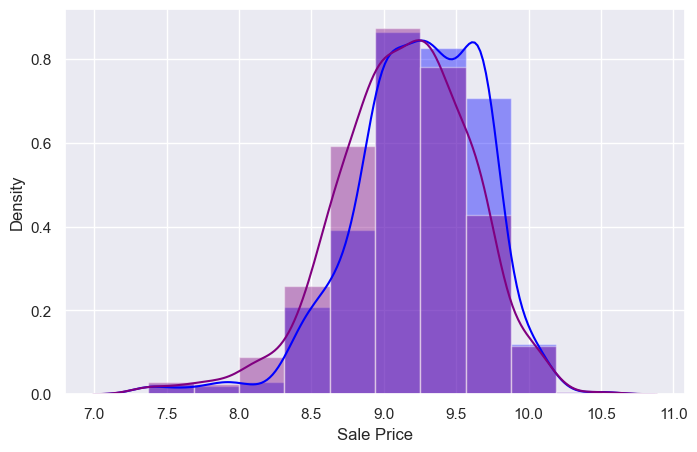

In [18]:
nike_brand = df[df['Brand'] == "Nike"]
sns.distplot(np.log(nike_brand['Listing Price']),bins=10,color='blue');
sns.distplot(np.log(nike_brand['Sale Price']),bins=10,color='purple');


Un cop ja solucionat els problemes amb la columna `Listing Price` podem confirmar que tant `Listing Price` com `Sale Price` tenen una distribució igual i en aquest cas causi no vaira el desplaçament d'una amb l'altre.

#### Discound

Tots els productes de la marca Nike tenien l'atribut Discound a 0 així que recalculem el descompte a partir de `Listing Price` i `Sale Price` per tal de poder utilitzar aquest atribut per una classificació futura.

In [19]:
df['Discount'] =np.round(100*(1- df['Sale Price']/df['Listing Price']))
df

,Listing Price,Sale Price,Discount,Brand,Rating,Reviews
0,14999,7499,50.0,Adidas ORIGINALS,4.8,41
1,7599,3799,50.0,Adidas ORIGINALS,3.3,24
2,999,599,40.0,Adidas CORE / NEO,2.6,37
3,6999,3499,50.0,Adidas CORE / NEO,4.1,35
4,7999,3999,50.0,Adidas ORIGINALS,3.5,72
...,...,...,...,...,...,...
3263,15995,12797,20.0,Nike,5.0,1
3264,4995,3497,30.0,Nike,0.0,0
3265,8495,5947,30.0,Nike,5.0,1
3266,16995,16995,0.0,Nike,4.0,4


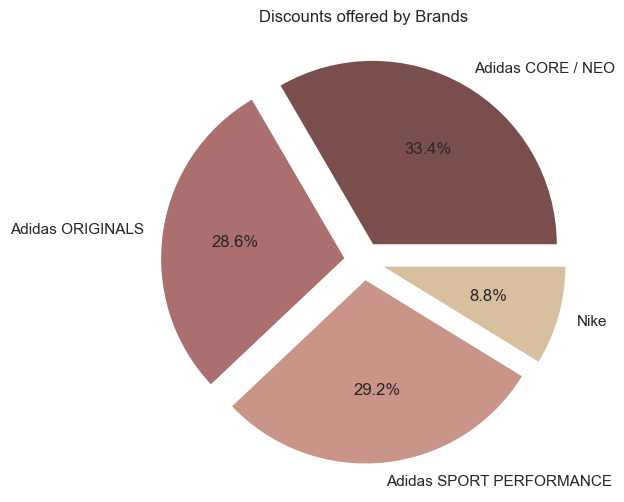

In [20]:
GroupedByBrands=df.groupby(df['Brand'])
AvgDis=GroupedByBrands.mean()
plt.subplots(figsize=(10,6));
discount=np.array(AvgDis.Discount)
label=AvgDis.index
plt.pie(x=discount,autopct="%.1f%%", explode=[0.10]*4,labels=label);
plt.title('Discounts offered by Brands');

Ponem veure que la marca que ofereix menys descomptes continua sent Nike.

#### Correlacions i histogrames

In [21]:
df['Sale Price'] = np.log(df['Sale Price']) 
df['Listing Price'] = np.log(df['Listing Price'])

<AxesSubplot:>

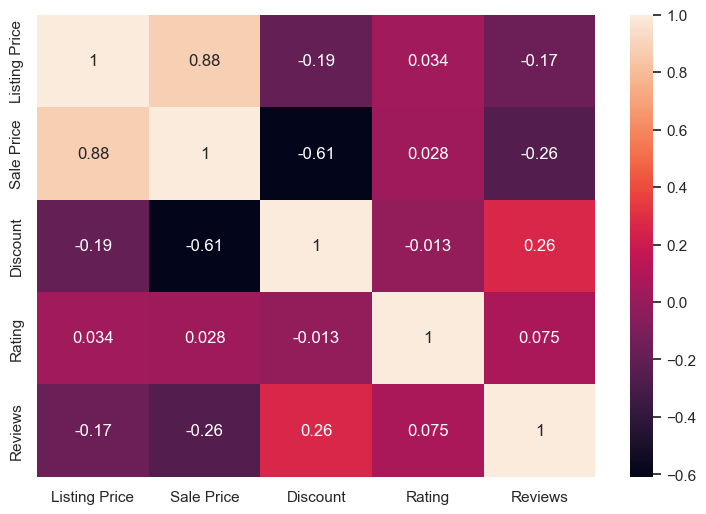

In [22]:
plt.figure(figsize=(9,6))
sns.heatmap(df.corr(method='spearman'),annot=True)

Veiem que les variables més correlacionades són `Sale Price` i `Listing Price` i la relació més destacable, es entre la variable descompte i el número de `Reviews` que té el producte, que és la següent més correlacionada i interpretem que com més descompte té el producte més `Reviews` obté.

array([[<AxesSubplot:title={'center':'Listing Price'}>,
        <AxesSubplot:title={'center':'Sale Price'}>],
       [<AxesSubplot:title={'center':'Discount'}>,
        <AxesSubplot:title={'center':'Rating'}>],
       [<AxesSubplot:title={'center':'Reviews'}>, <AxesSubplot:>]],
      dtype=object)

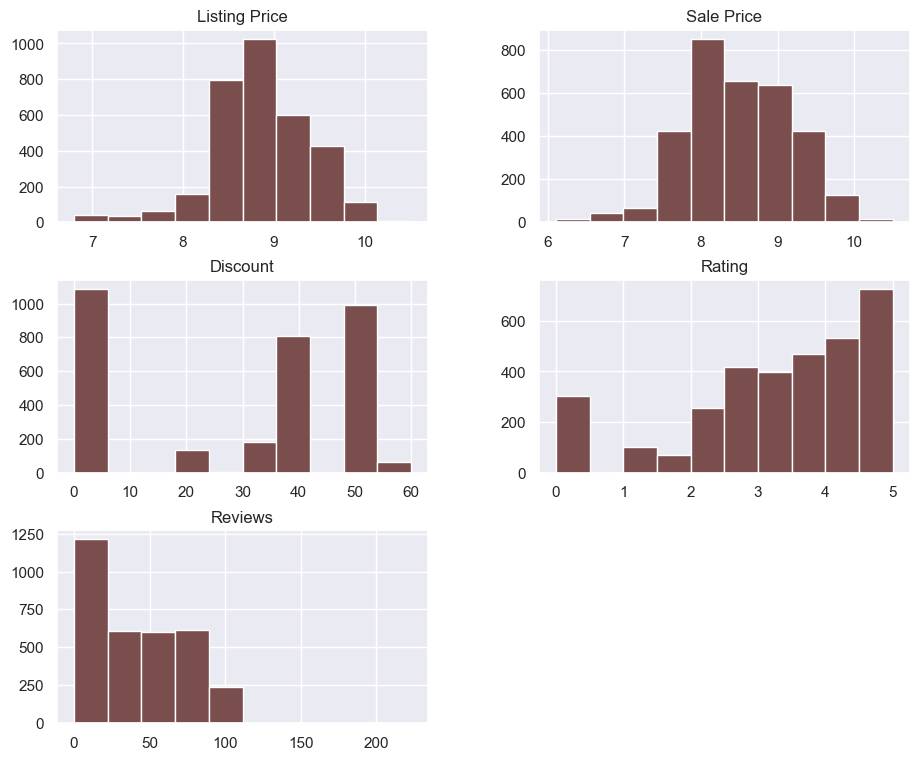

In [23]:
df.hist(figsize=(11,9))

<Figure size 900x600 with 0 Axes>

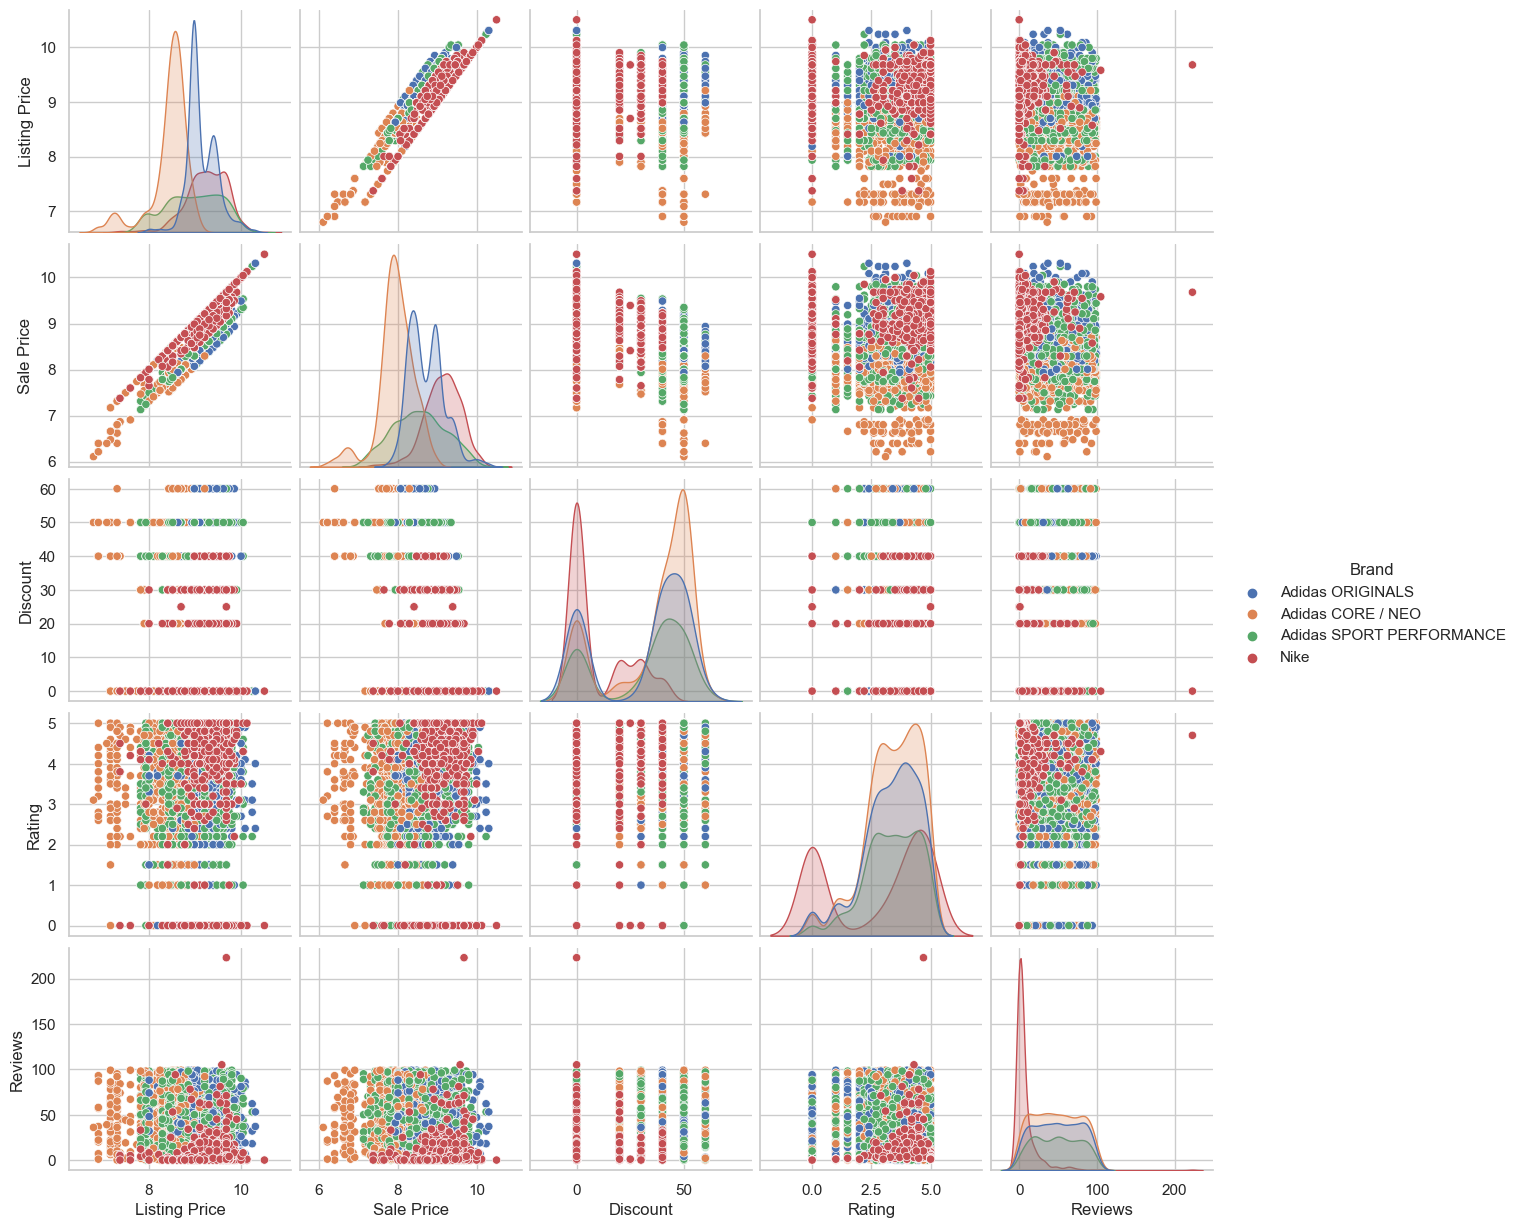

In [24]:
plt.figure(figsize=(9,6))
sns.set_theme(style='whitegrid')
sns.pairplot(df,hue = 'Brand')

## Classificació Marca 


Comencem implementant diferents mètodes de classificació amb el fi de poder predir quina marca és, tenint en compte la marca Nike i totes les marques incloses dintre d'Adidas.
Abans d'aplicar res separem la variable objectiu de la resta de variables i els hi fem una estandardització a totes elles.

In [25]:
#Separem dades
x = StandardScaler().fit_transform(df.drop(columns=['Brand']))
y = df['Brand']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [26]:
len(df['Brand'] == 'Adidas SPORT PERFORMANCE')
y_train.value_counts()

Adidas CORE / NEO           774
Adidas ORIGINALS            627
Nike                        451
Adidas SPORT PERFORMANCE    435
Name: Brand, dtype: int64

Per aquestes classificacions no es farà servir cap mena de tècnica de balanceig de dades, ja que, com es pot veure no està molt desequilibrat entre les diferents classes.

Per cada classificació es mostrarà la `precisió`, el `recall` i el `f1-score` de cada classe a predir.
A més a més, es mostrarà l'`accuracy` i el `Roc` de la classificació, juntament amb la `matriu de confusió`.

### LogisticRegression

                   precision    recall  f1-score   support

Adidas CORE / NEO       0.72      0.87      0.79       337
 Adidas ORIGINALS       0.63      0.77      0.69       281
             Nike       0.72      0.86      0.78       192

        micro avg       0.69      0.83      0.75       810
        macro avg       0.69      0.84      0.76       810
     weighted avg       0.69      0.83      0.75       810

accuracy is 0.6890927624872579
Roc is 0.8087800471178027


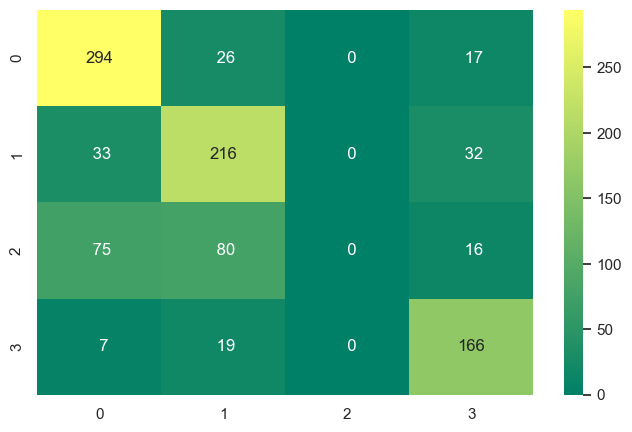

In [27]:
classifier = LogisticRegression()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print(f"Roc is {roc}")

A partir de les dades obtingudes veiem que té una precisió d'encert per `Adidas CORE / NEO` es del 0.72, per `Adidas ORIGINALS` un 0.63, per `Nike` un 0.71 i, en canvi, per `Adidas SPORT PERFORMANCE` no ha pogut classificar cap bé.
Tot i això, aconseguim una accuarcy del 0.689.

### SVM

                          precision    recall  f1-score   support

       Adidas CORE / NEO       0.72      0.87      0.79       337
        Adidas ORIGINALS       0.68      0.80      0.73       281
Adidas SPORT PERFORMANCE       0.54      0.09      0.15       171
                    Nike       0.79      0.88      0.83       192

                accuracy                           0.72       981
               macro avg       0.68      0.66      0.63       981
            weighted avg       0.69      0.72      0.67       981

accuracy is 0.7166156982670744
Roc is 0.861314884948564


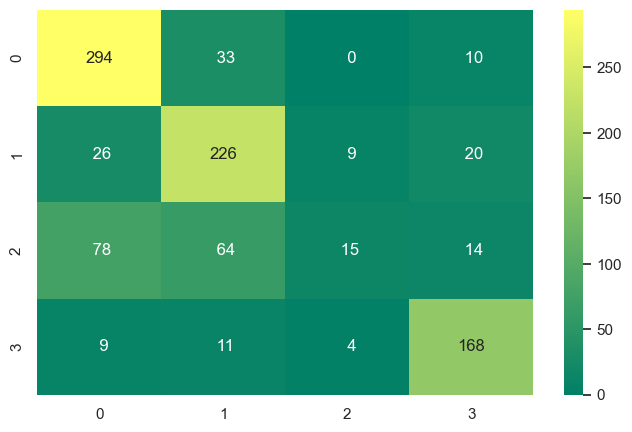

In [28]:
classifier = SVC(probability= True)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print(f"Roc is {roc}")

A partir de les dades obtingudes veiem que té una precisió d'encert per `Adidas CORE / NEO` es del 0.72, per `Adidas ORIGINALS` un 0.68, per `Nike` un 0.79 i en aquest cas  `Adidas SPORT PERFORMANCE`  ha obtingut un 0.54, la qual cosa ens diu que aquest model s'ajusta millor que l'anterior.
Com ara si ha pogut classificar millor, l'accuracy puja en aquest model al 0.717.

### K-Nearest

                          precision    recall  f1-score   support

       Adidas CORE / NEO       0.71      0.85      0.78       337
        Adidas ORIGINALS       0.65      0.74      0.70       281
Adidas SPORT PERFORMANCE       0.42      0.12      0.18       171
                    Nike       0.78      0.85      0.81       192

                accuracy                           0.69       981
               macro avg       0.64      0.64      0.62       981
            weighted avg       0.66      0.69      0.66       981

accuracy is 0.6921508664627931
Roc is 0.8549066775962814


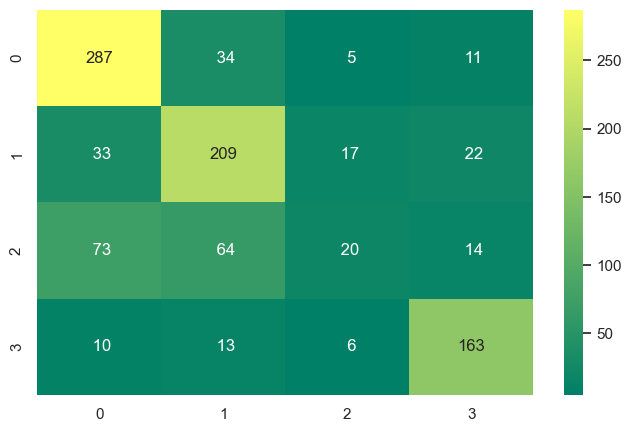

In [29]:
classifier = KNeighborsClassifier(n_neighbors=10)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print(f"Roc is {roc}")

Per aquest model obtenim un accuracy del 0.692 i veiem que la classe  millor classificada és `Nike`, amb un 78% d'encerts tot i ser una de les classes  amb menys mostres. Seguit d'aquest tenim a `Adidas CORE / NEO` amb un 71% d'encert, a `Adidas ORIGINALS` amb un 65% i, en últim lloc, a `Adidas SPORT PERFORMANCE` amb un 42%.


### Decision Tree's

                          precision    recall  f1-score   support

       Adidas CORE / NEO       0.74      0.75      0.75       337
        Adidas ORIGINALS       0.67      0.59      0.62       281
Adidas SPORT PERFORMANCE       0.34      0.43      0.38       171
                    Nike       0.91      0.84      0.87       192

                accuracy                           0.67       981
               macro avg       0.66      0.65      0.66       981
            weighted avg       0.68      0.67      0.67       981

accuracy is 0.6666666666666666
Roc is 0.7711701065935843


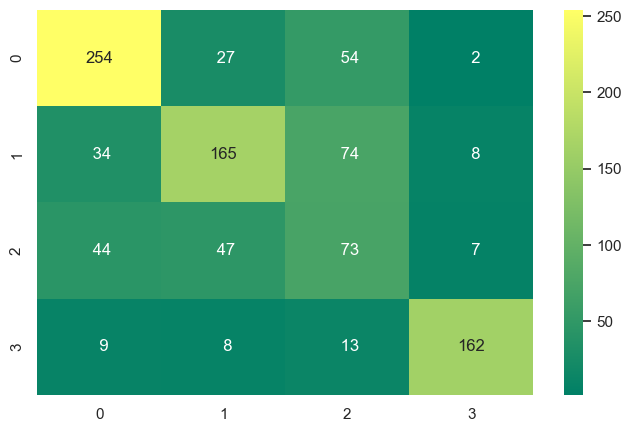

In [30]:
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print(f"Roc is {roc}")

Per aquest model obtenim un accuracy del 0.667 i veiem que la classe  millor classificada és `Nike`, amb un 91% d'encerts tot i ser una de les classes  amb menys mostres. Seguit d'aquest tenim a `Adidas CORE / NEO` amb un 74% d'encert, a `Adidas ORIGINALS` amb un 67% i, en últim lloc, a `Adidas SPORT PERFORMANCE` amb un 34%.


### Random Forest

                          precision    recall  f1-score   support

       Adidas CORE / NEO       0.78      0.88      0.83       337
        Adidas ORIGINALS       0.71      0.69      0.70       281
Adidas SPORT PERFORMANCE       0.49      0.39      0.43       171
                    Nike       0.88      0.87      0.87       192

                accuracy                           0.74       981
               macro avg       0.71      0.71      0.71       981
            weighted avg       0.73      0.74      0.73       981

accuracy is 0.7390417940876657
Roc is 0.8926025204887463


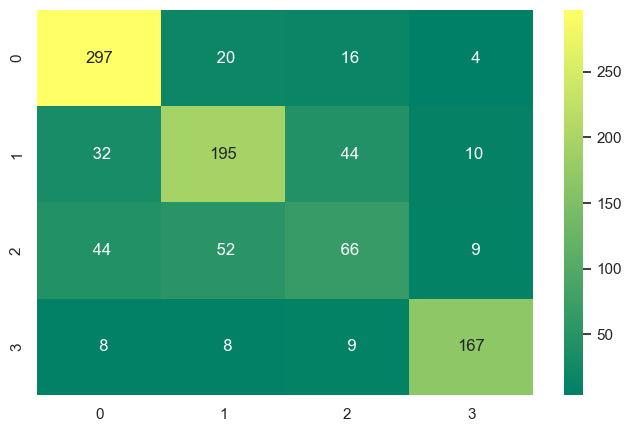

In [31]:
classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print(f"Roc is {roc}")

Per aquest model obtenim un accuracy del 0.739 i veiem que la classe  millor classificada és `Nike`, amb un 88% d'encerts tot i ser una de les classes  amb menys mostres. Seguit d'aquest tenim a `Adidas CORE / NEO` amb un 78% d'encert, a `Adidas ORIGINALS` amb un 71% i, en últim lloc, a `Adidas SPORT PERFORMANCE` amb un 49%.


### XGBoost

[00:04:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       281
           1       0.78      0.87      0.82       337
           2       0.49      0.40      0.44       171
           3       0.95      0.94      0.94       192

    accuracy                           0.76       981
   macro avg       0.74      0.73      0.73       981
weighted avg       0.75      0.76      0.75       981

accuracy is 0.7553516819571865
Roc is 0.9032191413890094


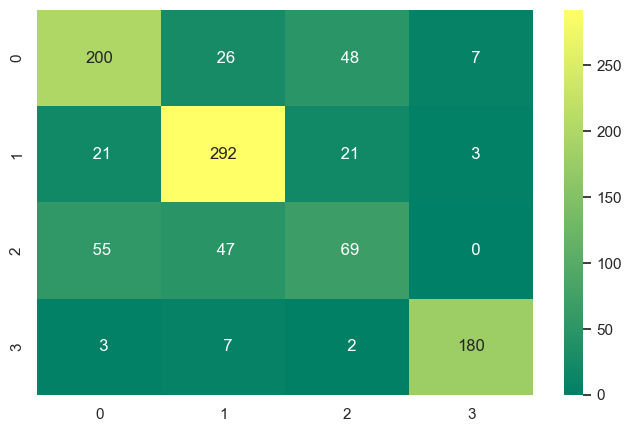

In [32]:
y_train.replace(['Adidas ORIGINALS', 'Adidas CORE / NEO', 'Adidas SPORT PERFORMANCE', 'Nike'], [0, 1, 2, 3], inplace=True)
y_test.replace(['Adidas ORIGINALS', 'Adidas CORE / NEO', 'Adidas SPORT PERFORMANCE', 'Nike'], [0, 1, 2, 3], inplace=True)

classifier = XGBClassifier(use_label_encoder=False)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print(f"Roc is {roc}")

Per acabar, en aplicar aquest model podem concloure que totes les classificacions estan acotades entre un 0.667 i un 0.755 d'acuraccy, sent els models amb millor classificació el `XGBoost` i `Random forest`. Tot i això, en tots els models coincideix que li costa molt classificar la classe `Adidas SPORT PERFORMANCE` no passant la meitat d'encerts en cap model, pitjor que llençar una moneda.

A més, a partir d'observar la matriu de confusió es veu que on més errors comet, és a l'hora de diferenciar entre la varietat de marques d'`Adidas`, així que amb aquesta nova informació modificarem l'atribut `Brand` amb el fi d'ajuntar totes les marques d'`Adidas` i fer un classificador binari entre `Nike` i `Adidas`.
Per poder tractar aquesta variació del dataset també haurem de trobar un mètode de balanceig de dades que es pugui ajustar bé a les nostres dades.

## Clasificació NikeVsAdidas

In [33]:
df['Brand']= df['Brand'].replace(['Adidas Adidas ORIGINALS','Adidas CORE / NEO','Adidas ORIGINALS','Adidas SPORT PERFORMANCE'],'Adidas')
df['Brand'].value_counts()

Adidas    2625
Nike       643
Name: Brand, dtype: int64

In [34]:
#Separem dades
x = StandardScaler().fit_transform(df.drop(columns=['Brand']))
y =df['Brand']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

Primer farem una classificació sense balanceig per veure el comportament de les dades i poder tenir una comparativa de la millora en la classificació.
En aquest cas per a cada classificació es mostrarà la `precisió`, el `recall` i el `f1-score` de cada classe a predir.
A més a més, es mostrarà l'`accuracy` i el `Roc` de la classificació, juntament amb la `matriu de confusió`, el temps d'execució total de cada classificació i els valors de la `cross validation` per assegurar-nos de no obtenir overfiting en el balanceig de les dades.

### RandomForestClassifier

              precision    recall  f1-score   support

      Adidas       0.98      0.98      0.98       794
        Nike       0.92      0.93      0.92       187

    accuracy                           0.97       981
   macro avg       0.95      0.95      0.95       981
weighted avg       0.97      0.97      0.97       981

accuracy is 0.9704383282364933
Roc is 0.9908605988766013

Execution time: 0.3199591636657715 seconds 



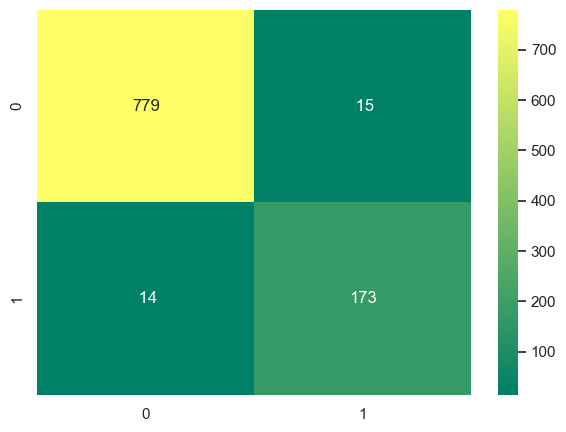

In [35]:
start_t=time.time()

classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc}")

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

Veiem que aplicant una `RandomForestClassifier` sense balanceig ja ens dona un accuracy del 0.970; tot i això, es pot veure com por `Adidas` ho encerta tot bastant bé, amb una precisió del 98% d'encerts, però que `Nike` tot i fer-ho millor que en els models anteriors, els quals cap passava del 50%, obtenim una precisió del 90%.


### RandomForestClassifier amb ajust dels pesos

              precision    recall  f1-score   support

      Adidas       0.98      0.99      0.98       794
        Nike       0.94      0.90      0.92       187

    accuracy                           0.97       981
   macro avg       0.96      0.94      0.95       981
weighted avg       0.97      0.97      0.97       981

accuracy is 0.9704383282364933
Roc is 0.9921537197429923 

Metrica del modelo 1.0
Metricas cross_validation [0.9628821  0.95414847 0.94967177 0.94748359 0.95404814]
Media de cross_validation 0.9536468137559362

Execution time: 0.8038513660430908 seconds 



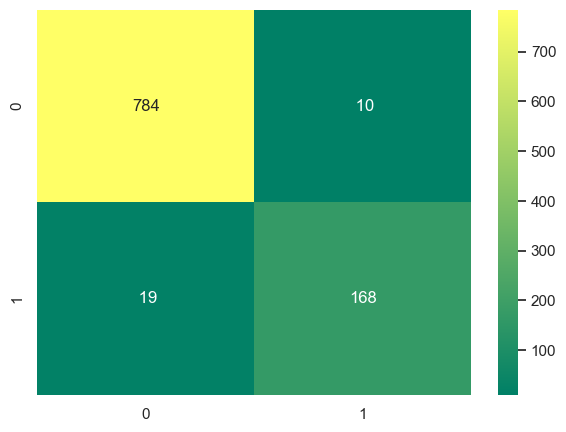

In [36]:
start_t=time.time()

classifier = RandomForestClassifier(class_weight="balanced")

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train,y_train)
scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")


Veiem com l'accuracy es manté i més o menys el rcall també així que provarem altres mètodes de balanceig, ja que aquest manté els resultats i no els millora.

### RandomForestClassifier amb Subsampling

Distribution before resampling Counter({'Adidas': 1831, 'Nike': 456})
Distribution after resampling Counter({'Adidas': 456, 'Nike': 456})
              precision    recall  f1-score   support

      Adidas       1.00      0.76      0.86       794
        Nike       0.49      0.98      0.65       187

    accuracy                           0.80       981
   macro avg       0.74      0.87      0.76       981
weighted avg       0.90      0.80      0.82       981

accuracy is 0.800203873598369
Roc is 0.968305068764396 

Metrica del modelo 1.0
Metricas cross_validation [0.95081967 0.90710383 0.96153846 0.94505495 0.94505495]
Media de cross_validation 0.9419143697832222

Execution time: 0.6419675350189209 seconds 



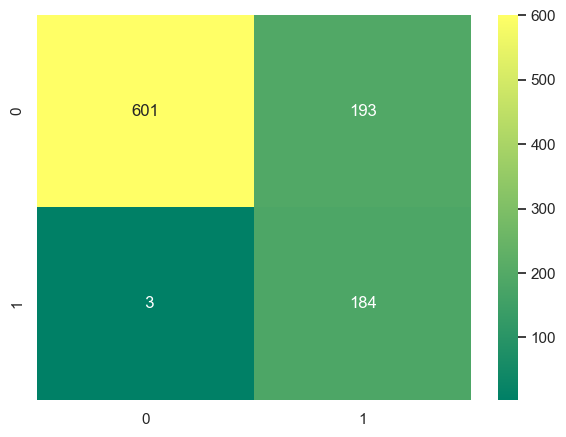

In [37]:
start_t=time.time()

us = NearMiss( n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

classifier = RandomForestClassifier()

classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train_res,y_train_res)
scores = cross_val_score(classifier, X_train_res, y_train_res, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

En aquest cas veiem com l'`acuraccy` disminueix a 0.800 així que descartem aquest mètode de balanceig, ja que no li va bé al nostre model.

### RandomForestClassifier amb Oversampling

Distribution before resampling Counter({'Adidas': 1831, 'Nike': 456})
Distribution labels after resampling Counter({'Adidas': 1831, 'Nike': 1831})
              precision    recall  f1-score   support

      Adidas       0.98      0.98      0.98       794
        Nike       0.91      0.94      0.92       187

    accuracy                           0.97       981
   macro avg       0.95      0.96      0.95       981
weighted avg       0.97      0.97      0.97       981

accuracy is 0.9694189602446484
Roc is 0.9940731960290413 

Metrica del modelo 1.0
Metricas cross_validation [0.96180082 0.96998636 0.96994536 0.99863388 1.        ]
Media de cross_validation 0.9800732821923528

Execution time: 1.0012664794921875 seconds 



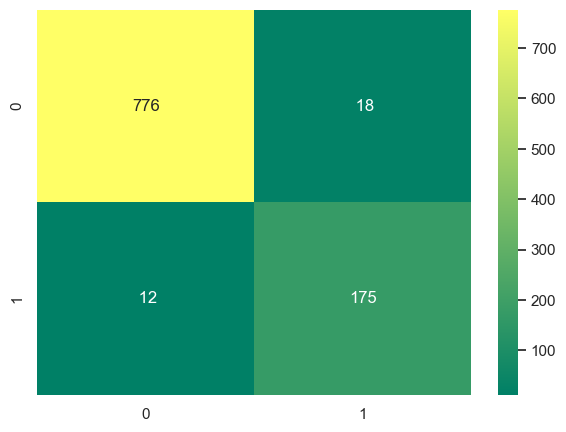

In [38]:
start_t=time.time()

os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))
classifier = RandomForestClassifier()

classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
    
print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train_res,y_train_res)
scores = cross_val_score(classifier, X_train_res, y_train_res, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

Veiem que obtenim un `accuracy` del 0.969 i `Nike` classifica bé un total del 175 mostres de 187 i `Adidas` un total de 776 mostres de 794.

### Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({'Adidas': 1831, 'Nike': 456})
Distribution after resampling Counter({'Adidas': 1818, 'Nike': 1818})
              precision    recall  f1-score   support

      Adidas       0.98      0.97      0.98       794
        Nike       0.88      0.93      0.91       187

    accuracy                           0.96       981
   macro avg       0.93      0.95      0.94       981
weighted avg       0.96      0.96      0.96       981

accuracy is 0.963302752293578
Roc is 0.9927464001400881 

Metrica del modelo 1.0
Metricas cross_validation [0.95604396 0.96148556 0.96011004 0.98624484 0.97111417]
Media de cross_validation 0.9669997128043896

Execution time: 1.1362738609313965 seconds 



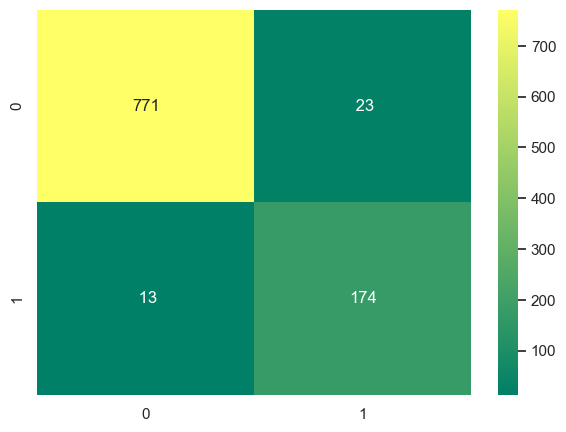

In [39]:
start_t=time.time()

os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))
classifier = RandomForestClassifier()


classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
    
print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train_res,y_train_res)
scores = cross_val_score(classifier, X_train_res, y_train_res, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

Obtenim un `accuracy` del 0.963, classificant pràcticament perfecte la classe d'`Adidas`, 771 mostres ben classificades de 794, i la classe `Nike` amb un 88% d'encert i un `rcall` de 0.93.

### Decision Tree amb randomUndersampling

              precision    recall  f1-score   support

      Adidas       0.98      0.96      0.97       794
        Nike       0.84      0.93      0.88       187

    accuracy                           0.95       981
   macro avg       0.91      0.94      0.93       981
weighted avg       0.96      0.95      0.95       981

accuracy is 0.9531090723751274
Roc is 0.9842569269521411 

Metrica del modelo 0.9790118058592042
Metricas cross_validation [0.94104803 0.92139738 0.93873085 0.9321663  0.93654267]
Media de cross_validation 0.9339770479584913

Execution time: 0.20706582069396973 seconds 



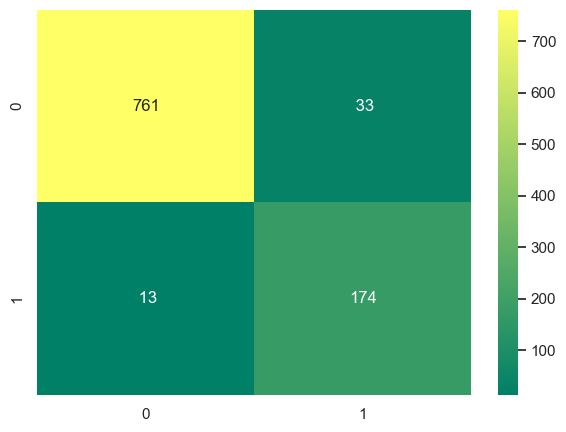

In [40]:
start_t=time.time()

classifier = BalancedBaggingClassifier()
 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
    
print(metrics.classification_report(y_test,y_pred,labels=np.unique(y_pred)))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train,y_train)
scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

Per aquest cas s'obte un `accuracy` del 0.940, classificant pràcticament perfecte la classe d'`Adidas`, 761 mostres ben classificades de 794, i la classe `Nike` amb un 84% d'encert i un `rcall` de 0.93.
Ja que hem obtingut millors mètodes de balanceig aquest el podem descartar.

### XGBoost amb Balanceig

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       794
           1       0.93      0.95      0.94       187

    accuracy                           0.98       981
   macro avg       0.96      0.97      0.96       981
weighted avg       0.98      0.98      0.98       981

accuracy is 0.9765545361875637
Roc is 0.9964843276444995 

Metrica del modelo 0.9995627459554001
Metricas cross_validation [0.97161572 0.9650655  0.96498906 0.96936543 0.96061269]
Media de cross_validation 0.9663296799900625

Execution time: 0.3788459300994873 seconds 



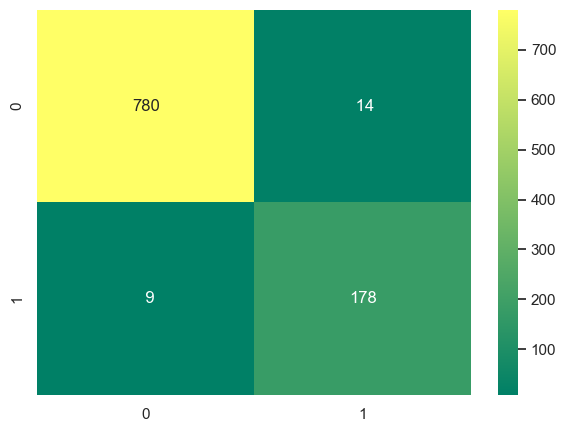

In [41]:
start_t=time.time()

y_train.replace(['Adidas', 'Nike'], [0, 1], inplace=True)
y_test.replace(['Adidas', 'Nike'], [0, 1], inplace=True)

classifier = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

classifier.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train,y_train)
scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

plt.subplots(figsize=(7,5));
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

Aquest mètode de classificació tenia una opció pròpia de balanceig i després d'aplicar-la veiem que com en el model de dades tractat al principi del treball la classificació per `XGBoost` és la que millors resultats s'obtenen.

Amb un `accuracy` del 0.977, una precisió en `Adidas` del 99%, una del 93% en `Nike` i un `recall` en els dos pròxims a 1. També aconseguim un `cross validation` del 0.97 el qual ens diu que és poc probable que en aquesta classificació s'hagi produït un overfit.


Veiem que de tots els models obtinguts els que millor han funcionat són `XGBoost` amb balanceig i `RandomForestClassifier amb Oversampling`, a partir d'això intentarem aplicar una PCA i fer una petita cerca d'hiperparametres per intentar maximitzar el màxim possible la precisió del nostre model.

### PCA

In [42]:
pca_best = PCA(0.95)
X_train95 = pca_best.fit_transform(X_train)
X_test95 = pca_best.transform(X_test)

print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")

Best PCA obtained with 4 components


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       794
           1       0.84      0.89      0.87       187

    accuracy                           0.95       981
   macro avg       0.91      0.93      0.92       981
weighted avg       0.95      0.95      0.95       981

accuracy is 0.9480122324159022
Roc is 0.9846307197025822 

Metrica del modelo 0.9982509838216004
Metricas cross_validation [0.9279476  0.930131   0.92560175 0.9321663  0.94091904]
Media de cross_validation 0.9313531384671248


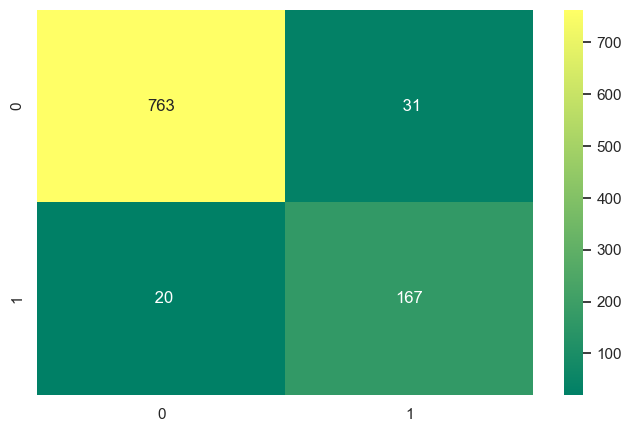

In [43]:
y_train.replace(['Adidas', 'Nike'], [0, 1], inplace=True)
y_test.replace(['Adidas', 'Nike'], [0, 1], inplace=True)

classifier = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

classifier.fit(X_train95, y_train, sample_weight = sample_weights)
y_pred = classifier.predict(X_test95)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test95)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
score = classifier.score(X_train95,y_train)
scores = cross_val_score(classifier, X_train95, y_train, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Tot i tenir un bon resultat de l'`accuracy` amb un 0.948, ens empitjora el nostre model així que descartem aplicar una `PCA` en el nostre classificador final.

### Busqueda hiperparametres

#### RandomForestClassifier

Fitting 10 folds for each of 54 candidates, totalling 540 fits
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       794
           1       0.94      0.91      0.93       187

    accuracy                           0.97       981
   macro avg       0.96      0.95      0.95       981
weighted avg       0.97      0.97      0.97       981

accuracy is 0.9724770642201835
Roc is 0.9934535756138956 

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Metrica del modelo 1.0
Metricas cross_validation [0.96589359 0.98362892 0.97677596 0.9931694  1.        ]
Media de cross_validation 0.9838935730846361

Execution time: 121.41095757484436 seconds 



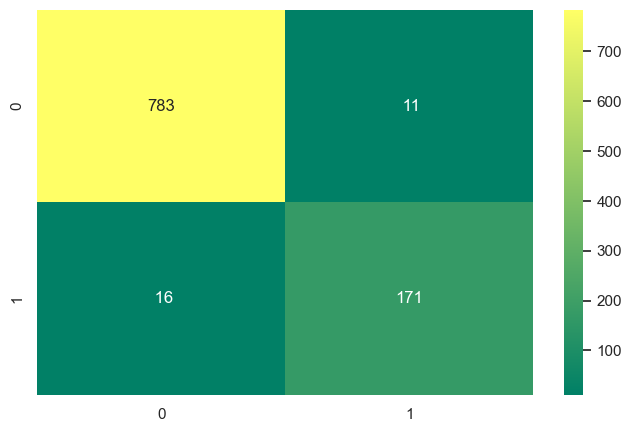

In [44]:
start_t=time.time()
rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
RandomForest = RandomForestClassifier()

classifier = GridSearchCV(RandomForest, rf_param_grid, cv = StratifiedKFold(n_splits = 10),
                       scoring = "accuracy",
                       n_jobs = -1,verbose = 2 )

classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)

print(metrics.classification_report(y_test,y_pred))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")


kf = KFold(n_splits=5)
score = classifier.score(X_train_res,y_train_res)
scores = cross_val_score(classifier, X_train_res, y_train_res, cv=kf, scoring="accuracy")

print("Metrica del modelo", score)
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

#### XGBoost

Fitting 10 folds for each of 96 candidates, totalling 960 fits
accuracy is 0.9775739041794088
Roc is 0.99676046282951 

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Metricas cross_validation [0.9650655  0.96724891 0.96936543 0.97374179 0.96936543]
Media de cross_validation 0.9689574116365514

Execution time: 191.130375623703 seconds 



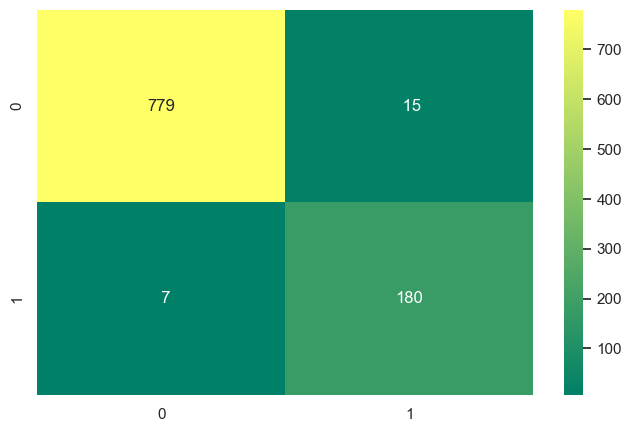

In [45]:

y_train.replace(['Adidas', 'Nike'], [0, 1], inplace=True)
y_test.replace(['Adidas', 'Nike'], [0, 1], inplace=True)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

start_t=time.time()

xgb_model = XGBClassifier(use_label_encoder=False,objective= 'binary:logistic',eval_metric='logloss')
classifier = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv = StratifiedKFold(n_splits = 10), 
                   scoring='roc_auc', verbose=True)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

classifier.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = classifier.predict(X_test)
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
print(f"accuracy is {metrics.accuracy_score(y_pred,y_test)}")

roc = metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print(f"Roc is {roc} \n")

kf = KFold(n_splits=5)
scores = cross_val_score(classifier, X_train, y_train, cv=kf, scoring="accuracy")

print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())

Et_L=time.time() - start_t
print(f"\nExecution time: {Et_L} seconds \n")

Després d'aplicar una cerca d'hiperparametres sobre els 2 millors classificadors obtingudes veiem que ens dona un `accuracy` es practicament igual del que ja teníem i mirant el temps d'execució que triga cada una, 130 segons per `RandomForest` i 190 segons per `XGBoost` aproximadament, descartem aquestes opcions, ja que comparant-les amb altres triguen massa temps.

## Conclusions

El millor model obtingut ha sigut una classificació `Nike` i `Adidas` aplicant un `XGBoots` amb balanceig amb un accuracy del 0.97.
Com a millores futures del treball aplicaria un bucle for per tal de fer cada classificació un seguit de cops i poder veure així cap on tendeix el valor real de l'`accuracy`. D'aquesta manera sabríem bé qui és el millor model, ja que a l'hora de fer els diferents tipus de balanceig de dades les diferències entre els accuracys eren petites i poder una cerca més exhaustiva del valor real de l'acuracy ens portaria a escollir un altre model d'equilibri de dades.